In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [79]:
df = pd.read_csv("D:/전력예측/train.csv", encoding='euc-kr')

In [80]:
def coding(df):
    df = df.rename(columns={'num':'건물번호',
                       '전력사용량(kWh)':'전력사용량',
                       '기온(°C)':'기온',
                       '풍속(m/s)':'풍속',
                       '습도(%)':'습도',
                       '강수량(mm)':'강수량',
                       '일조(hr)':'일조'})
    return(df)
df = coding(df)

### 1. 기초 전처리
#### (1) type 확인

In [111]:
print(df.shape)
print('-'*100)
print(df.info())
print('-'*100)
print(df.isnull().sum())

(122400, 16)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   건물번호       122400 non-null  int64         
 1   date_time  122400 non-null  datetime64[ns]
 2   전력사용량      122400 non-null  float64       
 3   기온         122400 non-null  float64       
 4   풍속         122400 non-null  float64       
 5   습도         122400 non-null  float64       
 6   강수량        122400 non-null  float64       
 7   일조         122400 non-null  float64       
 8   비전기냉방설비운영  122400 non-null  float64       
 9   태양광보유      122400 non-null  float64       
 10  연도         122400 non-null  int64         
 11  월          122400 non-null  int64         
 12  일          122400 non-null  int64         
 13  시간         122400 non-null  int64         
 14  요일

#### - date_time의 type을 datetime형으로 변경 뒤, 연월일, 시간, 요일 변수 생성

In [81]:
df['date_time'] = pd.to_datetime(df['date_time'])

# 연도, 월, 일, 시간 column 생성
df['연도'] = df['date_time'].dt.year
df['월'] = df['date_time'].dt.month
df['일'] = df['date_time'].dt.day
df['시간'] = df['date_time'].dt.hour

#### - dayofweek는 Pandas에서 제공하는 DatetimeIndex 객체나 Timestamp 객체의 속성 중 하나로, 해당 날짜의 요일을 정수 형태로 표현
#### - 요일은 0부터 시작하여 월요일이 0, 일요일이 6

In [85]:
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

df['요일'] = df['date_time'].apply(weekday)
df['주말'] = df['date_time'].apply(weekend)

In [88]:
print(df['건물번호'].unique())
print(df['비전기냉방설비운영'].unique())
print(df['태양광보유'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
[0. 1.]
[0. 1.]


In [155]:
for column in df.columns:
    print(column, df[column].unique())
    print('-'*100)

건물번호 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
----------------------------------------------------------------------------------------------------
date_time ['2020-06-01T00:00:00.000000000' '2020-06-01T01:00:00.000000000'
 '2020-06-01T02:00:00.000000000' ... '2020-08-24T21:00:00.000000000'
 '2020-08-24T22:00:00.000000000' '2020-08-24T23:00:00.000000000']
----------------------------------------------------------------------------------------------------
전력사용량 [8179.056 8135.64  8107.128 ... 4294.08  4212.432 3975.696]
----------------------------------------------------------------------------------------------------
기온 [17.6 17.7 17.5 17.1 17.  16.9 16.7 17.8 19.3 20.5 22.1 23.1 23.6 23.8
 24.4 22.7 21.3 19.8 18.6 17.9 17.2 16.6 16.2 15.9 15.7 15.5 14.8 15.
 16.  17.3 16.3 20.4 20.9 21.7 21.2 20.6 20.3 19.9 19.6 19.  18.4 18.3
 18.2 18.1 19.7 2

#### - 건물번호: 60개 건물들에 대한 데이터
#### 즉, 건물번호별로 비전기냉방설비운영, 태양광보유 여부가 똑같을 것
#### 예를 들어 1번 건물은 태양광보유, 2번 건물은 미보유 뭐 이런식일 것임
#### 나중에 건물번호별로 groupby하여 분포를 살펴볼 필요가 있을 것

In [87]:
df.columns

Index(['건물번호', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조',
       '비전기냉방설비운영', '태양광보유', '연도', '월', '일', '시간', '요일', '주말'],
      dtype='object')

#### - 종속변수: 전력사용량
#### - 범주형변수: 건물번호, 비전기냉방설비운영, 태양광보유, 연도, 월, 일, 시간, 요일, 주말
#### - 연속형변수: 기온, 풍속, 습도, 강수량, 일조

### 전처리 정리 코드

In [107]:
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

def coding(df):
    df = df.rename(columns={'num':'건물번호',
                       '전력사용량(kWh)':'전력사용량',
                       '기온(°C)':'기온',
                       '풍속(m/s)':'풍속',
                       '습도(%)':'습도',
                       '강수량(mm)':'강수량',
                       '일조(hr)':'일조'})
    
    df['date_time'] = pd.to_datetime(df['date_time'])

    # 연도, 월, 일, 시간 column 생성
    df['연도'] = df['date_time'].dt.year
    df['월'] = df['date_time'].dt.month
    df['일'] = df['date_time'].dt.day
    df['시간'] = df['date_time'].dt.hour
    
    df['요일'] = df['date_time'].apply(weekday)
    df['주말'] = df['date_time'].apply(weekend)
    
    return(df)

### 2. 변수간 상관 및 분포 확인

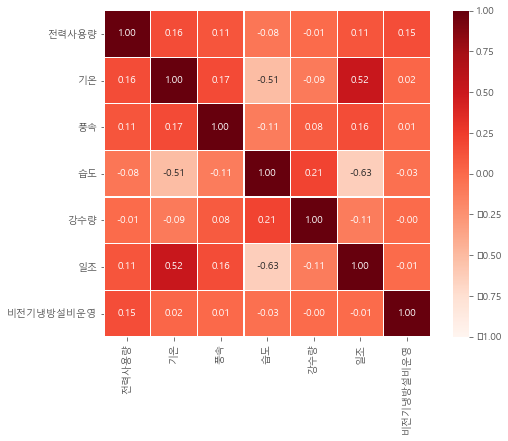

In [110]:
cor = df.iloc[:,1:9].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(cor, 
            linewidths = 0.1, #셀 사이 선을 집어넣음 
            vmax = 1.0, #최댓값 
            vmin = -1.0, #최솟값 
            square = True, 
            cmap = 'Reds',#맵 색깔
            linecolor = "white", #셀 사이 라인 색깔 
            annot = True, #각 셀의 표기 유무 및 그 값의 데이터타입 설정 
            fmt = '.2f', #각 셀의 값의 데이터 형태 (만약 소수2째자리까지 한다면 '.2f')
            annot_kws = {"size" : 10} #셀 안의 폰트 크기
           )
plt.show();

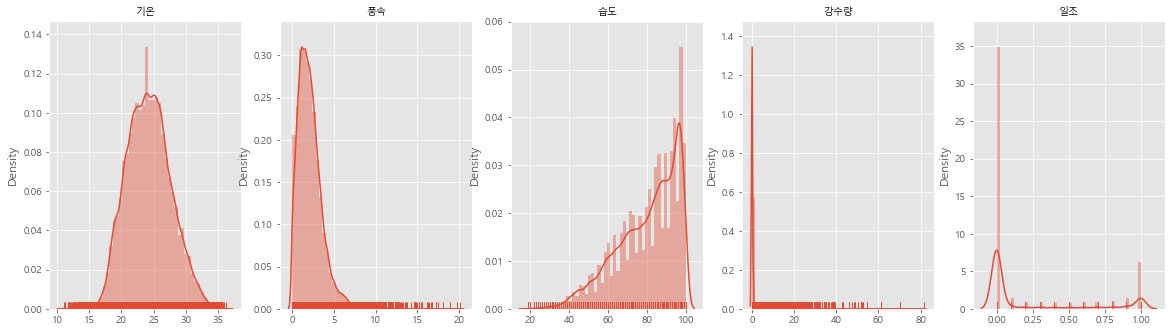

In [103]:
import warnings
warnings.filterwarnings( 'ignore' )

plt.figure(figsize=(20, 5)) # 가로, 세로 
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

column = ['기온', '풍속', '습도', '강수량', '일조']
df_eda = df[column]

for i in range(len(df_eda.columns)):
  col = df_eda.columns[i]
  plt.subplot(1, 5, i+1)
  sns.distplot(x=df_eda[col], kde=True, rug=True)
  plt.title(col, fontsize=10)

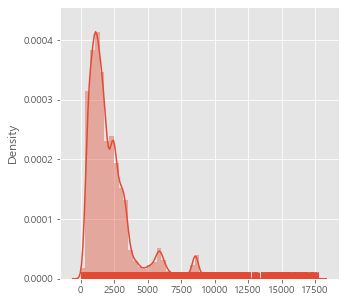

In [106]:
plt.figure(figsize=(5, 5)) # 가로, 세로 
sns.distplot(x=df['전력사용량'], kde=True, rug=True)
plt.show();

#### - 전체 데이터를 기준으로 봤을 때, 낮은 상관
#### - 연속형 변수의 분포를 봤을 때, 기온을 빼면 정규분포가 아님

### (3) 건물번호 그룹화

In [135]:
df_mean = df.groupby(['건물번호'])['전력사용량'].mean().sort_values(ascending=False)
df_sum = df.groupby(['건물번호'])['전력사용량'].sum().sort_values(ascending=False)

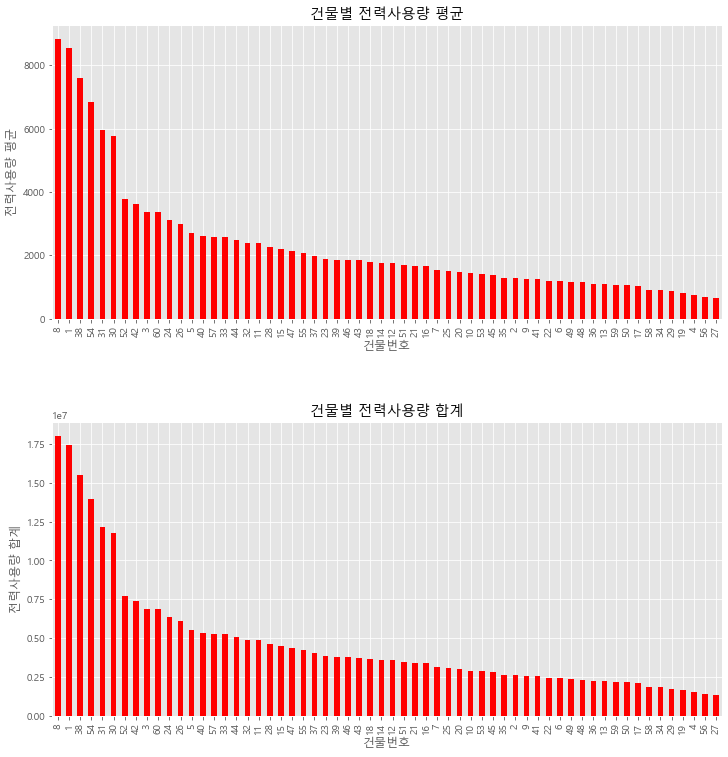

In [140]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35) #서브플롯 간 간격 조정

plt.subplot(2,1,1)
df_mean.plot(kind='bar', color='red')
plt.title('건물별 전력사용량 평균')
plt.xlabel('건물번호')
plt.ylabel('전력사용량 평균')

plt.subplot(2,1,2)
df_sum.plot(kind='bar', color='red')
plt.title('건물별 전력사용량 합계')
plt.xlabel('건물번호')
plt.ylabel('전력사용량 합계')

plt.show()

#### - 건물별 전력사용량 평균과 합계를 살펴보면, 건물별로 양상이 다른 것을 확인할 수 있음
#### 아이디어1. 건물특성 파악 이후, 군집화